# Notebook overview

## Goals

- Data Exploration
    - The data are inspected to identify structure, data-types, data classes, distributions, missing values, etc.
- Data Reduction
    - Only a representative subsample of the dataset is kept for more efficient data analysis
    - Irrelevant features are removed (e.g., date, business ID)
- Data Cleaning
    - Data are cleaned to ensure no missing values, duplicates, etc.
    - Minimal cleaning of the review text is performed, e.g., replacing odd whitespaces, backslashes, etc.

## Data

### Raw

- Yelp review dataset (https://www.yelp.com/dataset)
- Accessible from kaggle as `yelp-dataset` (https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset)
- Description from the kaggle dataset page:
> This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the most recent dataset you'll find information about businesses across 8 metropolitan areas in the USA and Canada.
- Specifically, I analyze the `yelp_academic_dataset_review.json` file which contains data pertaining to Yelp user reviews and includes the text of the review and an associated 1-5 star rating of the Yelp user's experience (among other data, e.g., date, business ID, etc.)
- Data are indexed per review with no discernable sorting

## Libraries

- `pandas` used to read, load, store, inspect, process, and save the data (https://pandas.pydata.org/)
- `matplotlib` and `seaborn` for plotting

## Output

- `/kaggle/working/data/interim/cleaned-reduced-data.json` - a reduced subset of the raw data that has been cleaned and prepared for NLP
- `/kaggle/working/figures/star-counts.pdf` - plot of the class distribution

# Environment Setup

- I will mainly be using `pandas` at this stage
- The module from `IPython` ensures every command in a cell is displayed, which saves me from having to write lots of print statements

In [2]:
# Libraries for reading, handling, and visualizing data
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# For quickly getting file lengths
from subprocess import check_output

# Settings for displaying commands in a cell
from IPython.core.interactiveshell import InteractiveShell

- Some settings for the notebook that aid with analysis

In [3]:
# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Set seaborn style and color palette
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#1B998B','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Data Exploration, Reduction, and Cleaning

## Data exploration - file size, structure

- I'll now explore the data, reducing and cleaning in situ
- Start by opening the input file `/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json`
- Read the first line to get a sense for how the file is structured

In [4]:
# Inspect the structure of the Yelp review data json file using a single entry
RAW_PATH = '/kaggle/input/yelp-dataset/'
OUT_PATH = '/kaggle/working/'

# Save all figures to this directory
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)
    
# Save all intermediate data to this directory
DATA_PATH = os.path.join(OUT_PATH, 'data')
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
INT_DATA_PATH = os.path.join(DATA_PATH, 'interim')
if not os.path.exists(INT_DATA_PATH):
    os.mkdir(INT_DATA_PATH)
    
with open(os.path.join(RAW_PATH,'yelp_academic_dataset_review.json'), 'r') as json_file:
    json_file.readline()

'{"review_id":"KU_O5udG6zpxOg-VcAEodg","user_id":"mh_-eMZ6K5RLWhZyISBhwA","business_id":"XQfwVwDr-v0ZS3_CbbE5Xw","stars":3.0,"useful":0,"funny":0,"cool":0,"text":"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it\'s other locations in NJ and never had a bad experience. \\n\\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.","date":"2018-07-07 22:09:11"}\n'

- It is apperent that a single line is a self-contained json object corresponding to a single observation (review)
- The keys are data labels and the values are data values
- Let's see how many observations this file contains

In [5]:
# Get the number of lines in the json file, equal to the number of data observations (reviews)
int(check_output(['wc', '-l', INPUT_FILE]).split()[0])

6990280

- Almost 7 million reviews! This is far more than I will need for analysis and will slow the processing down considerably
- Before I take a subsample, let's make sure that the reviews are not ordered in any meaningful way
- This lets us just truncate the data rather than having to randomly sample it which can take time (pass through first m < n lines rather than all n lines)

In [6]:
# Read and inspect the first few lines of the json file to see if review data are shuffled
# Use a pandas dataframe for easier inspection
df_head_10 = pd.read_json(os.path.join(RAW_PATH,'yelp_academic_dataset_review.json'), lines=True, nrows=10)
df_head_10.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
8,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
9,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06


- There does not appear to be sorting in any column, so we will assume the data are properly shuffled

## Data reduction - subsampling

- I will truncate the number of lines read so we only load a representative subsample of the total data
- Read a subsample of the data from the input file `/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json` and load into a pandas dataframe

In [7]:
# Read the Yelp review data
# Dataset is large (~7 million reviews!) 
# Read the first 20,000 lines of the input file and load the data subsample into a pandas dataframe for analysis 
READ_SIZE = 20000
df = pd.read_json(os.path.join(RAW_PATH,'yelp_academic_dataset_review.json'), lines=True, nrows=READ_SIZE)

## Data exploration - structure, dtypes, null values, duplicates

- After reading and loading the data subsample, I inspect the contents of the dataframe: identify the data-types, check for null entries and duplicates, and peek the first few rows of data

In [8]:
# Inspect the size and data-types of the df
df.info()

# Check for null/missing values
df.isnull().values.any()

# Check for any duplicate entries
df.duplicated().values.any()

# Inspect the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    20000 non-null  object        
 1   user_id      20000 non-null  object        
 2   business_id  20000 non-null  object        
 3   stars        20000 non-null  int64         
 4   useful       20000 non-null  int64         
 5   funny        20000 non-null  int64         
 6   cool         20000 non-null  int64         
 7   text         20000 non-null  object        
 8   date         20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 1.4+ MB


False

False

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


- Fortunately there are no null-valued or duplicate entries in our sample
- We can see there are 9 columns with int and str data-types

## Data reduction - feature selection

- I am only interested in the "text" and "stars" columns for the purposes of sentiment analysis
- Remove all but these two columns from the dataframe

In [9]:
# Remove columns we will not need from the df
# For building a sentiment classifier we will only need to keep:
# 1. Written reviews ("text") for training features
# 2. Star ratings ("stars") for training targets
df = df[['stars','text']]

## Data exploration - class distributions
- Let's explore the star ratings in the 'stars' column, which will serve as our categories or class labels
- Start by inspecting the 'stars' column to understand the values

In [10]:
# Check the values of the class labels ("stars")
sorted(pd.unique(df['stars']))
len(pd.unique(df['stars']))

[1, 2, 3, 4, 5]

5

- We can see the values are integers ranging from 1 to 5
- This might seem obvious, but it's good to check since these will become our class labels
- Now look at how these values are distributed

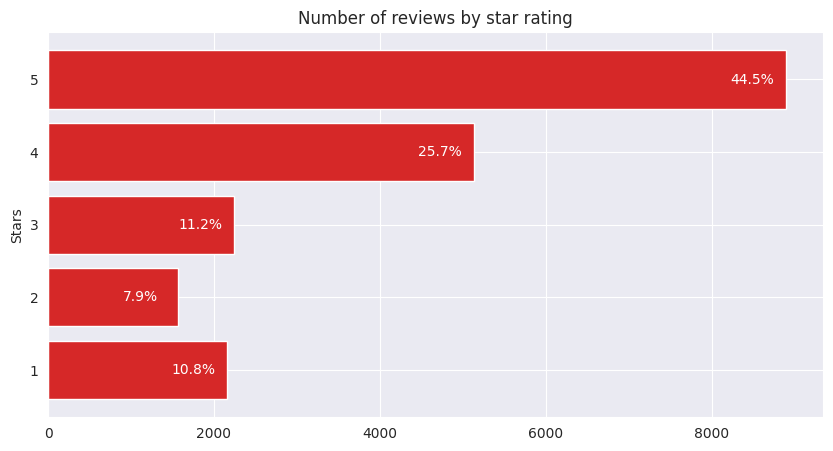

In [11]:
df_counts = df['stars'].value_counts().sort_index()
df_fracs = df['stars'].value_counts(normalize=True).sort_index()

# Inspect the distribution of classes in the dataset
ax = df_counts.plot(figsize=(10,5), kind='barh', width=.8, title='Number of reviews by star rating')

# Annotate bars with the percentage
percent_labels = [f'{100*p:.1f}%' for p in df_fracs]
ax.bar_label(ax.containers[0], labels=percent_labels, label_type='edge', fontsize=10, color='white', padding=-40)

# Clean up x- and y-axes
ax.set(xlabel=None)
ax.set(ylabel='Stars')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'star-counts.pdf'), bbox_inches='tight');

- The data are heavily bias toward 5 star ratings, followed by 4 stars.
- There are slightly more 1 star ratings than 2 star
- This is not very surprising: people are more inclined to leave positive reviews after a great experience with a business, and are more likely to give strong statements like 5 stars or 1 stars, than neutral statements, say, 2 or 3 stars
- I am slightly surprised there are not more 1 star reviews, as I imagine many people feel inclined to leave feedback after a very negative experience
- Based on a cursury read of some of the more negative sounding reviews, is seems as though negative reviews are just distributed among the 1, 2, and 3 star ratings, i.e., even a very negatively written review can be awarded a 2 or even 3 star rating
- I could reduce the data by taking a subset with a uniform distribution of star ratings, as training a model on data with an uneven class distribution can lead to bias
- There is also a good reason to keep this distribution, as it is a real feature of user sentiment and we want a model that will reflect that
- I will retain this data and make that decision later in the analysis
- This also allows me to group the classes down the road for, say, a binary classifier, with greater data retention

## Data cleaning - text data

- Now I focus on cleaning the text data, i.e., the written review of the business
- Start by checking for odd whitespaces including:
    - newline characters `\n`
    - tabs `\t`
    - backslashes or escape characters `\`
    - double spaces, tripple spaces, etc.

In [12]:
# Now let's clean up the textual data

# This let's us see the entire text of each review - better for analysis
pd.set_option('display.max_colwidth', 10000)

# Search for any odd whitespace or backslashes in the text
df['text'].str.contains('\n', regex=True).any() # newline
df['text'].str.contains('\t', regex=True).any() # tab
df['text'].str.contains('  ', regex=True).any() # double space
df['text'].str.contains(r'\\', regex=True).any() # backslash

True

False

True

True

- There are newline characters, backslashes, and double spaces present
- Let's take a look at an example of each occurance

In [13]:
# Look at a couple examples of each
pd.set_option('display.max_colwidth', 10000) # display the entire review
df[df['text'].str.contains('\n', regex=True) == True]['text'].head(1)
df[df['text'].str.contains(r'\\', regex=True) == True]['text'].head(1)
df[df['text'].str.contains('  ', regex=True) == True]['text'].head(1)

0    If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.
Name: text, dtype: object

1450    When my daughter was about a year-and-a-half old, Linda, the owner, helped me out by taking her for a drop in a couple times. My daughter is now four and a half and I have a one-and-a-half-year-old son. I switched school districts from Carson to Washoe and I kept going to all of these other daycare places and not getting a great feel, as well as the fact that they were totally booked for having an infant\toddler. I needed a place for both of my kids and there was just no where for my son..... My gut kept telling me go back to Circle of Friends. I've been extremely happy. Are there always going to be kids who attended daycare that I do not agree with their behavior? absolutely! There is no way to get around that whether it is in school, daycare, or a sports team or some other organized deal. I try the best of my ability to not let those other children's behaviors influence my own and we talk about it. Well the best you can for a 4 year old! I really like Linda and the whole staf

3    Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korma.  With 10 different kinds of naan!!!  Don't let the outside deter you (because we almost changed our minds)...go in and try something new!   You'll be glad you did!
Name: text, dtype: object

- In the first example there are several `\n` chars
- In the second example we see a `\` in "`4\5 stars`" which is likely just a typo that the Yelp user intended as a `/` (also back-to-back `\n` chars)
- In the last example, there is a double space, also likely a typo

- While we could apply different replacements in each case, for the purposes of sentiment analysis it is sufficient to replace all of these whitespaces/backslashes with a single space; it will not drastically change the meaning of the text
- Replace the whitespaces and add the cleaned text as a new column to the dataframe
- Verify the cleaned data look as expected
- N.B. Punctuation and special characters will be dealt with in a separate module, where we use a pretrained English langauge model to tokenize the text

In [14]:
# Replace all whitespace and backslashes with a single space
df['cleaned_text'] = df['text'].str.replace('\s+', ' ', regex=True)
df['cleaned_text'] = df['cleaned_text'].str.replace(r'\\', ' ', regex=True)

# Verify the changes with the same examples
df[df['text'].str.contains('\n', regex=True) == True]['cleaned_text'].head(1)
df[df['text'].str.contains(r'\\', regex=True) == True]['cleaned_text'].head(1)
df[df['text'].str.contains('  ', regex=True) == True]['cleaned_text'].head(1)

0    If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.
Name: cleaned_text, dtype: object

1450    When my daughter was about a year-and-a-half old, Linda, the owner, helped me out by taking her for a drop in a couple times. My daughter is now four and a half and I have a one-and-a-half-year-old son. I switched school districts from Carson to Washoe and I kept going to all of these other daycare places and not getting a great feel, as well as the fact that they were totally booked for having an infant toddler. I needed a place for both of my kids and there was just no where for my son..... My gut kept telling me go back to Circle of Friends. I've been extremely happy. Are there always going to be kids who attended daycare that I do not agree with their behavior? absolutely! There is no way to get around that whether it is in school, daycare, or a sports team or some other organized deal. I try the best of my ability to not let those other children's behaviors influence my own and we talk about it. Well the best you can for a 4 year old! I really like Linda and the whole staf

3    Wow! Yummy, different, delicious. Our favorite is the lamb curry and korma. With 10 different kinds of naan!!! Don't let the outside deter you (because we almost changed our minds)...go in and try something new! You'll be glad you did!
Name: cleaned_text, dtype: object

- At this point, the text data are clean of any odd whitespace and non-English characters
- I could clean the text data further, such as removing numbers, punctuation, etc., but I will do that in a separate module focused on processing English text with specialized tools

## Data reduction - feature selection

- Now I will drop any columns I no longer need:
    - `text` - the raw, un-cleaned text
- Double check the data in the remaining columns look as expected

In [15]:
# We can now drop the unprocessed text column
df = df.drop(columns=['text'])
df.head()

,stars,cleaned_text
0,3,"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."
1,5,"I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out. For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do). There is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking your butt in class!"
2,3,"Family diner. Had the buffet. Eclectic assortment: a large chicken leg, fried jalapeño, tamale, two rolled grape leaves, fresh melon. All good. Lots of Mexican choices there. Also has a menu with breakfast served all day long. Friendly, attentive staff. Good place for a casual relaxed meal with no expectations. Next to the Clarion Hotel."
3,5,"Wow! Yummy, different, delicious. Our favorite is the lamb curry and korma. With 10 different kinds of naan!!! Don't let the outside deter you (because we almost changed our minds)...go in and try something new! You'll be glad you did!"
4,4,"Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today. Cheese curds were very good and very filling. Really like that sandwiches come w salad, esp after eating too many curds! Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked. Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses. Lots of beer and wine as well as limited cocktails. Next time I will try one of the draft wines."


# Save interim data

- I can finally save the reduced and cleaned data as an output file for use in other modules
- I am saving the data in the JSON format to remain consistent with the input files

In [16]:
# The data are now prepared!
# The next step will be to process the text data and featurize the text and class labels

# Save the current state of the data so it can be read by other notebooks
df.to_json(os.path.join(INT_DATA_PATH, 'cleaned-reduced-data.json'), orient='records', lines=True)

# Read the saved data back in to verify the format
df = pd.read_json(os.path.join(INT_DATA_PATH, 'cleaned-reduced-data.json'), orient='records', lines=True)

# Inspect the size and data-types of the df
df.info()

# Inspect the first few rows
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   stars         20000 non-null  int64 
 1   cleaned_text  20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


,stars,cleaned_text
0,3,"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."
1,5,"I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out. For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do). There is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking your butt in class!"
2,3,"Family diner. Had the buffet. Eclectic assortment: a large chicken leg, fried jalapeño, tamale, two rolled grape leaves, fresh melon. All good. Lots of Mexican choices there. Also has a menu with breakfast served all day long. Friendly, attentive staff. Good place for a casual relaxed meal with no expectations. Next to the Clarion Hotel."
3,5,"Wow! Yummy, different, delicious. Our favorite is the lamb curry and korma. With 10 different kinds of naan!!! Don't let the outside deter you (because we almost changed our minds)...go in and try something new! You'll be glad you did!"
4,4,"Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today. Cheese curds were very good and very filling. Really like that sandwiches come w salad, esp after eating too many curds! Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked. Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses. Lots of beer and wine as well as limited cocktails. Next time I will try one of the draft wines."
